<a href="https://colab.research.google.com/github/yurizza/Belajar-Pengembangan-Machine-Learning/blob/main/timeseries_daily_gold_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Time Series: Gold Prediction (1985 - 2023)
* Nama: Cici Yuriza
* Email: ciciyuriza999@gmail.com
* Id Dicoding: yuriza

Goal: Developing a time series model for daily gold price prediction.

Dataset: [Gold Rates (1985-Jan 2022) Dataset](https://www.kaggle.com/datasets/hemil26/gold-rates-1985-jan-2022)

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# define folder path in drive
folder_path = '/content/drive/MyDrive/dicoding/'

In [ ]:
# # unzip folder in drive

# import zipfile

# # define folder path
# zip_file_path = folder_path + 'gold.zip'

# # define folder path for unzip folder
# extracted_folder = folder_path + 'TimeSeries'

# # Create a ZipFile object
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the contents into the specified folder
#     zip_ref.extractall(extracted_folder)

In [ ]:
# import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# read data
df = pd.read_csv(folder_path+'TimeSeries/daily_gold_rate.csv')
df.head()

,Date,USD,EUR,GBP,INR,AED,CNY
0,1985-01-01,308.30,402.45,266.01,3825.85,1134.42,NaN
1,1985-01-02,305.50,401.49,266.00,3787.05,1134.42,NaN
2,1985-01-03,302.30,397.08,262.76,3718.88,1107.67,NaN
3,1985-01-04,303.15,397.15,262.58,3759.64,1118.21,NaN
4,1985-01-07,298.25,392.55,261.17,3741.23,1091.58,835.8


In [ ]:
# show data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10114 non-null  object 
 1   USD     10114 non-null  float64
 2   EUR     10114 non-null  float64
 3   GBP     10114 non-null  float64
 4   INR     10114 non-null  float64
 5   AED     10114 non-null  float64
 6   CNY     10110 non-null  float64
dtypes: float64(6), object(1)
memory usage: 553.2+ KB


In [ ]:
# Check missing value
df.isnull().sum()

Date    0
USD     0
EUR     0
GBP     0
INR     0
AED     0
CNY     4
dtype: int64

CNY has 4 missing value

In [ ]:
# Change data type 'Date' from 'object' to 'datetime'
df['Date'] = pd.to_datetime(df['Date'])

USA Daily Gold Prediction

In [ ]:
# Define an empty DataFrame
df_clean = pd.DataFrame()

In [ ]:
# Just take column date and usd
df_clean['date'] = df['Date'].values
df_clean['usd'] = df['USD'].values

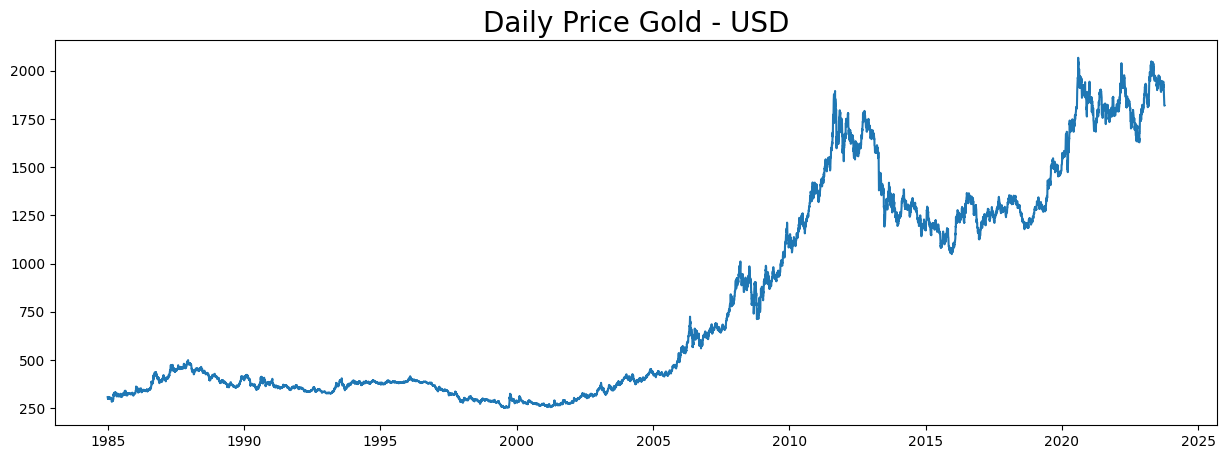

In [ ]:
# show data
plt.figure(figsize=(15,5))
plt.plot(df_clean['date'], df_clean['usd'])
plt.title('Daily Price Gold - USD', fontsize=20);

In [ ]:
# taking only gold price as values and datetime feature as index in the dataframe for time series forecasting of daily gold price
data = pd.DataFrame(list(df_clean['usd']), index=df_clean['date'], columns=['usd'])

In [ ]:
# check data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10114 entries, 1985-01-01 to 2023-10-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usd     10114 non-null  float64
dtypes: float64(1)
memory usage: 158.0 KB


In [ ]:
# Show 5 first rows of data
data.head()

,usd
date,
1985-01-01,308.30
1985-01-02,305.50
1985-01-03,302.30
1985-01-04,303.15
1985-01-07,298.25


In [ ]:
# calculate missing value
data.usd.isna().sum()

0

In [ ]:
# Scaling data to get rid of outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

In [ ]:
data['usd_scaled'] = data_scaled
data.head()

,usd,usd_scaled
date,,
1985-01-01,308.30,-0.938821
1985-01-02,305.50,-0.941908
1985-01-03,302.30,-0.945435
1985-01-04,303.15,-0.944498
1985-01-07,298.25,-0.949899


Splitiing Data

In [ ]:
# Spling data into train and test with ratio 80:20
X = data.index
y = data['usd_scaled'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print('Jumlah Data Training = ',X_train.shape[0])
print('Jumlah Data Testing = ',X_test.shape[0])

Jumlah Data Training =  8091
Jumlah Data Testing =  2023


Check Threshold

In [ ]:
# Check threshold for MAE
max_skala_data = data_scaled.max()
min_skala_data = data_scaled.min()
threshold_mae = (max_skala_data - min_skala_data) * (10 / 100)
print('Max value: ' , max_skala_data)
print('Min Value: ', min_skala_data)
print('Threshold MAE:', threshold_mae)

Max value:  1.0000000000000002
Min Value:  -1.0
Threshold MAE: 0.2


Windowed Dataset

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Expand dimensions to make it suitable for TensorFlow Dataset
    series = tf.expand_dims(series, axis=-1)

    # Create a TensorFlow Dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the dataset by creating overlapping windows with specified size and shift
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the overlapping windows and create batches of data
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # Shuffle the dataset to introduce randomness
    ds = ds.shuffle(shuffle_buffer)

    # Map each window to a tuple (input, target) where input is all values except the last one and target is the last value
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    # Batch the dataset and prefetch one batch to improve performance
    return ds.batch(batch_size).prefetch(1)


Define Callback with MAE < 0.05

In [ ]:
# callback
# Stop epoch when MAE < 0.05
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.05):
      self.model.stop_training = True
      print('\nFor Epoch', epoch, ' training has been stopped.''\n Because MAE of the model has reach < 10% of data scale')

callbacks = CallBack()

Define Model Machine Learning using LSTM layers

In [ ]:
# Define the windowed datasets for training and testing
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

# Define the LSTM model using a Sequential
model = tf.keras.models.Sequential([
    # LSTM layer with 60 units, return sequences to pass the sequence to the next LSTM layer
    tf.keras.layers.LSTM(60, return_sequences=True),

    # Second LSTM layer with 60 units
    tf.keras.layers.LSTM(60),

    # Dense layer with 30 units and ReLU activation function
    tf.keras.layers.Dense(60, activation="relu"),

    # Dense layer with 30 units and ReLU activation function
    tf.keras.layers.Dense(30, activation="relu"),

    # Dense layer with 10 units and ReLU activation function
    tf.keras.layers.Dense(10, activation="relu"),

    # Output layer with 1 unit (for regression tasks)
    tf.keras.layers.Dense(1),
])

Training Model

In [ ]:
# Define the SGD optimizer with a specific learning rate and momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-02, momentum=0.9)

# Compile the model with Huber loss and the specified optimizer and metric (MAE)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model using the training set and validate on the test set for 200 epochs
# Use a verbosity level of 2 to show progress during training
# callback functions for stop epoch when MAE < 0.05
history = model.fit(train_set, epochs=200, validation_data=test_set, verbose=2, callbacks=[callbacks])


Epoch 1/200
81/81 - 7s - loss: 0.0656 - mae: 0.2542 - val_loss: 0.1233 - val_mae: 0.4249 - 7s/epoch - 86ms/step
Epoch 2/200
81/81 - 2s - loss: 0.0491 - mae: 0.2189 - val_loss: 0.0903 - val_mae: 0.3421 - 2s/epoch - 22ms/step
Epoch 3/200
81/81 - 3s - loss: 0.0547 - mae: 0.2309 - val_loss: 0.0569 - val_mae: 0.2724 - 3s/epoch - 40ms/step
Epoch 4/200
81/81 - 3s - loss: 0.0820 - mae: 0.2807 - val_loss: 0.0595 - val_mae: 0.2863 - 3s/epoch - 36ms/step
Epoch 5/200
81/81 - 2s - loss: 0.1014 - mae: 0.3222 - val_loss: 0.1016 - val_mae: 0.3595 - 2s/epoch - 26ms/step
Epoch 6/200
81/81 - 2s - loss: 0.0938 - mae: 0.3247 - val_loss: 0.0294 - val_mae: 0.1849 - 2s/epoch - 26ms/step
Epoch 7/200
81/81 - 2s - loss: 0.0419 - mae: 0.2145 - val_loss: 0.0340 - val_mae: 0.1982 - 2s/epoch - 22ms/step
Epoch 8/200
81/81 - 2s - loss: 0.0273 - mae: 0.1720 - val_loss: 0.0372 - val_mae: 0.2151 - 2s/epoch - 26ms/step
Epoch 9/200
81/81 - 4s - loss: 0.0185 - mae: 0.1433 - val_loss: 0.0475 - val_mae: 0.2597 - 4s/epoch - 46

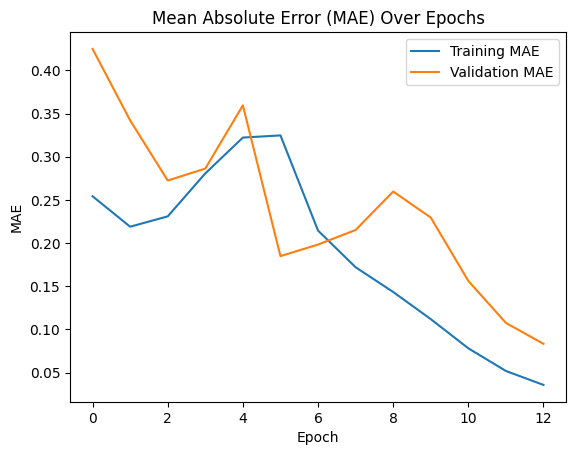

In [ ]:
# Plot the Mean Absolute Error (MAE) over epochs for training and validation sets
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

# Set the title and axis labels for the plot
plt.title('Mean Absolute Error (MAE) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')

# Display a legend to distinguish between training and validation MAE
plt.legend(loc='upper right')

# Show the plot
plt.show()


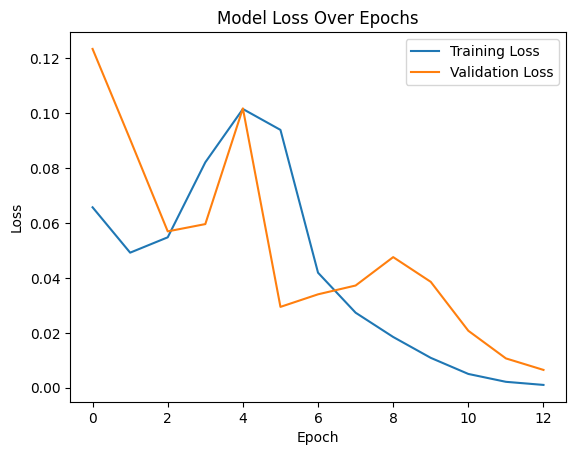

In [ ]:
# Plot the model loss over epochs for training and validation sets
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title and axis labels for the plot
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display a legend to distinguish between training and validation loss
plt.legend(loc='upper right')

# Show the plot
plt.show()

Testing Model Using Validation Data

In [ ]:
window_size = 60  # Define the window size

# Predict using the model on the test data
forecast = []

# Iterate through the time steps in the test data
for time in range(len(y_test) - window_size):
    # Extract the corresponding time window
    series_window = np.array([y_test[time:time + window_size]])

    # Reshape series_window to match the expected input shape of the model
    series_window = series_window.reshape((series_window.shape[0], series_window.shape[1], 1))

    # Perform prediction using the model
    prediction = model.predict(series_window)

    # Save the predicted result
    forecast.append(prediction[0, 0])

1/1 [==============================] - 0s 29ms/step


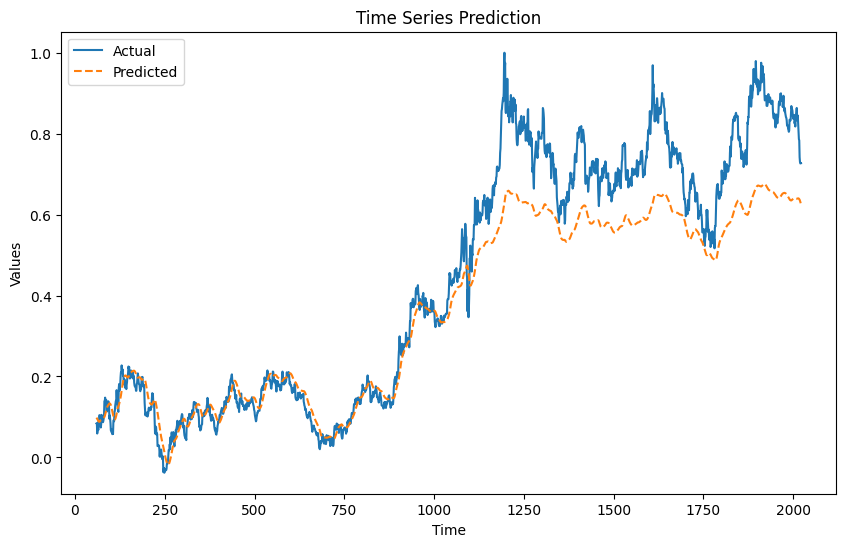

In [ ]:
# Extract the actual time labels
time_labels = np.arange(len(y_test))

# Plot the predicted vs. actual time series
plt.figure(figsize=(10, 6))

# Plot the actual values starting from the window size
plt.plot(time_labels[window_size:], y_test[window_size:], label='Actual')

# Plot the predicted values with a dashed line
plt.plot(time_labels[window_size:], forecast, label='Predicted', linestyle='dashed')

# Set the title and axis labels for the plot
plt.title('Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Values')

# Display a legend to distinguish between actual and predicted values
plt.legend()

# Show the plot
plt.show()

Conclusions for Daily Gold Prediction:

1. The dataset spans from 1985 to 2023, comprising 10,114 samples.
2. A train-test split ratio of 80:20 is applied for model evaluation.
3. Data normalization is performed using the Min-Max Scaler, mapping values to the range of -1 to 1.
3. Windowed datasets with a window size of 60, batch size of 100, and shuffle buffer of 1000 are created for model training.
4. A threshold of 0.2, representing less than 10% of the data scale, is set, leading to an MAE threshold of less than 0.05.
5. The learning rate applied is 0.01.
6. Model performance on the training set: loss of 0.0010, MAE of 0.0356.
7. Model performance on the validation set: loss of 0.0065, MAE of 0.0833.